# Boosting Models
## Import Libraries

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mutual_info_score

## Import Train and Test Datasets

In [4]:
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv('Data/X_test_engineered.csv')
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 99)
Test Set  : (8176, 1) (8176, 99)


In [419]:
# helper function for calculating evaluation scores
def evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, version, train_metrics, test_metrics):
    train_metric = {
    "Version": version,
    "Accuracy": accuracy_score(Y_train, Y_train_pred),
    "Precision": precision_score(Y_train, Y_train_pred),
    "Recall": recall_score(Y_train, Y_train_pred),
    "F1 Score": f1_score(Y_train, Y_train_pred)
    }

    test_metric = {
        "Version": version,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }

    # Save to overall metrics dataframe for comparison later
    if len(train_metrics)==0:
        train_metrics = pd.DataFrame.from_records([train_metric])
        test_metrics = pd.DataFrame.from_records([test_metric])
    else:
        train_metrics = pd.concat([train_metrics, pd.DataFrame.from_records([train_metric])], ignore_index = True)
        test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

    # Calculate general metrics for the train set
    print("**Training Set Metrics**")
    print("Accuracy \t:", train_metric["Accuracy"])
    print("Precision \t:", train_metric["Precision"])
    print("Recall \t\t:", train_metric["Recall"])
    print("F1 Score \t:", train_metric["F1 Score"])

    print() # New Line

    # Calculate general metrics for the test set
    print("**Test Set Metrics**")
    print("Accuracy \t:", test_metric["Accuracy"])
    print("Precision \t:", test_metric["Precision"])
    print("Recall \t\t:", test_metric["Recall"])
    print("F1 Score \t:", test_metric["F1 Score"])
    
    return train_metrics, test_metrics

In [332]:
# helper function for plotting permutation_importance
def plot_feature_importance(feature_importance, feature_names):
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, feature_importance)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

In [ ]:
# helper function for calculating mutual information
def calculate_mutual_info(df, col1, col2):
    return mutual_info_score(df[col1], df[col2])

In this notebook, we will explore several promising Boosting methods, as listed below:
1. Gradient Boosting : Gradient Boosting builds a strong predictive model by combining an ensemble of weak learners, typically decision trees. It works by iteratively fitting new models to the residual errors of the previous models, with each subsequent model focusing on the areas where the previous ones performed poorly.
2. AdaBoost: AdaBoost is a boosting algorithm that combines multiple weak classifiers to build a strong classifier. It assigns weights to the training instances and focuses on the misclassified instances in subsequent iterations, adjusting the weights accordingly. Each weak classifier is trained sequentially, with more emphasis placed on the instances that are difficult to classify correctly.
3. XGBoost: XGBoost is an optimized implementation of gradient boosting, designed to be highly efficient, scalable, and accurate. It includes several enhancements over traditional gradient boosting, such as regularization techniques to prevent overfitting, parallelization of tree construction, and support for additional loss functions.
4. LightGBM: LightGBM is another gradient boosting framework that is designed for efficiency and speed. It uses a novel tree-based learning algorithm that splits the tree leaf-wise instead of level-wise, which reduces the number of nodes to be split and leads to faster training times. LightGBM also supports features like categorical feature optimization and parallel training.

For each model, we will first train it with all available features on the default setting, then apply feature selection method to select the optimal set of features, and perform hyperparameter tuning. The performance of the model in each stage will be observed and compared.

For Boosting models, there are 2 common ways for feature selection:
1. In-built Feature Importance Score: Boosting algorithms compute feature importance scores during the training process. Feature importance scores are typically based on metrics such as the total reduction in impurity (e.g., Gini impurity or entropy) achieved by splitting on a particular feature across all decision trees in the ensemble. These scores reflect the contribution of each feature to the overall performance of the model.
2. Permutation Importance: It assesses the importance of each feature by measuring how much the model's performance deteriorates when the values of that feature are randomly shuffled (permuted). The drop in performance after permutation reflects the importance of the feature: a larger drop indicates a more important feature, while a smaller drop suggests a less important feature. Permutation importance provides a more robust assessment of feature importance compared to feature importance scores, as it directly measures the impact of each feature on the model's performance.

Compared to Recursive Feature Elimination, in-built feature selection methods like feature importance scores and permutation importance are generally preferred in the context of boosting algorithms, as they offer a more comprehensive and efficient approach to feature selection based on the model's behavior and performance.

### Gradient Boosting

In [5]:
from sklearn.ensemble import GradientBoostingClassifier

In [416]:
# Set up a dataframe to store the results from different versions
train_metrics = pd.DataFrame(columns=['Version', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
test_metrics = pd.DataFrame(columns=['Version', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

#### Build the Baseline Model

In [405]:
gb = GradientBoostingClassifier(random_state=47).fit(X_train, Y_train.values.ravel())

In [406]:
# Predict the output based on our training and testing dataset
Y_train_pred = gb.predict(X_train)
Y_test_pred = gb.predict(X_test)

In [420]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred, Y_test, Y_test_pred, "Baseline", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8537171439780306
Precision 	: 0.8620620419636583
Recall 		: 0.8421930168693605
F1 Score 	: 0.8520117080914819

**Test Set Metrics**
Accuracy 	: 0.8302348336594912
Precision 	: 0.6368715083798883
Recall 		: 0.40665873959571935
F1 Score 	: 0.49637155297532654


#### Eliminate the Features with permutation_importance=0

In [334]:
# Compute permutation importance
pi_result = permutation_importance(gb, X_train, Y_train.values.ravel(), random_state=47, n_repeats=10)

In [375]:
# Get feature importance score
feature_importances = pi_result['importances_mean']
# Get feature names
feature_names = X_train.columns

# Remove features with permutation_importance=0
feature_names = feature_names[feature_importances>0]
feature_importances = feature_importances[feature_importances>0]

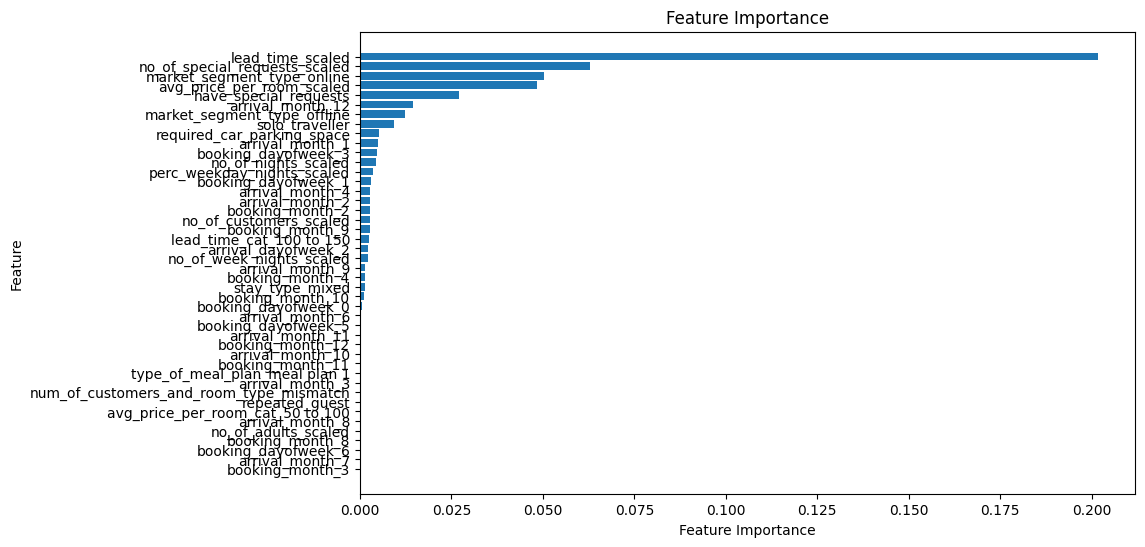

In [376]:
# Get indices that would sort feature importances
sorted_indices = np.argsort(feature_importances)
# Visualize permutation_importance
plot_feature_importance(feature_importances[sorted_indices], feature_names[sorted_indices])


In [377]:
selected_columns = feature_names[sorted_indices]

#### Fit the Model again the selected set of features

In [411]:
gb_selected = GradientBoostingClassifier(random_state=47).fit(X_train[selected_columns], Y_train.values.ravel())

In [412]:
# Predict the output based on our training and testing dataset
Y_train_pred_selected = gb_selected.predict(X_train[selected_columns])
Y_test_pred_selected = gb_selected.predict(X_test[selected_columns])

In [422]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_selected, Y_test, Y_test_pred_selected, "Feature Selected", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8503825029423303
Precision 	: 0.8598046127505288
Recall 		: 0.8372891329933307
F1 Score 	: 0.8483975155279503

**Test Set Metrics**
Accuracy 	: 0.8313356164383562
Precision 	: 0.6391184573002755
Recall 		: 0.41379310344827586
F1 Score 	: 0.5023457235654999


#### Hyperparameter Tuning

For GradientBoostingClassifier, there are several hyperparameters to tune:
1. n_estimators (default=100): The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
2. learning_rate (default=0.1): Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.
3. max_depth (default=3): Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree.
4. min_samples_split (default=2): The minimum number of samples required to split an internal node.
5. min_samples_leaf (default=1): The minimum number of samples required to be at a leaf node.
6. subsample (default=1.0): The fraction of samples to be used for fitting the individual base learners.
7. max_features (default=None): The number of features to consider when looking for the best split.

##### Tuning n_estimators

In [254]:
parameters_n_estimators = {
    'n_estimators': range(10, 150, 10),
    }
model = GradientBoostingClassifier(random_state=47)
grid_search_n_estimators = GridSearchCV(model, param_grid=parameters_n_estimators, cv=5, scoring='f1', verbose=3)
grid_search_n_estimators.fit(X_train[selected_columns], Y_train.values.ravel())

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END ...................n_estimators=10;, score=0.821 total time=   0.1s
[CV 2/5] END ...................n_estimators=10;, score=0.795 total time=   0.1s
[CV 3/5] END ...................n_estimators=10;, score=0.782 total time=   0.1s
[CV 4/5] END ...................n_estimators=10;, score=0.777 total time=   0.1s
[CV 5/5] END ...................n_estimators=10;, score=0.774 total time=   0.1s
[CV 1/5] END ...................n_estimators=20;, score=0.826 total time=   0.3s
[CV 2/5] END ...................n_estimators=20;, score=0.796 total time=   0.3s
[CV 3/5] END ...................n_estimators=20;, score=0.806 total time=   0.3s
[CV 4/5] END ...................n_estimators=20;, score=0.797 total time=   0.3s
[CV 5/5] END ...................n_estimators=20;, score=0.778 total time=   0.3s
[CV 1/5] END ...................n_estimators=30;, score=0.833 total time=   0.4s
[CV 2/5] END ...................n_estimators=30;

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=47),
             param_grid={'n_estimators': range(10, 150, 10)}, scoring='f1',
             verbose=3)

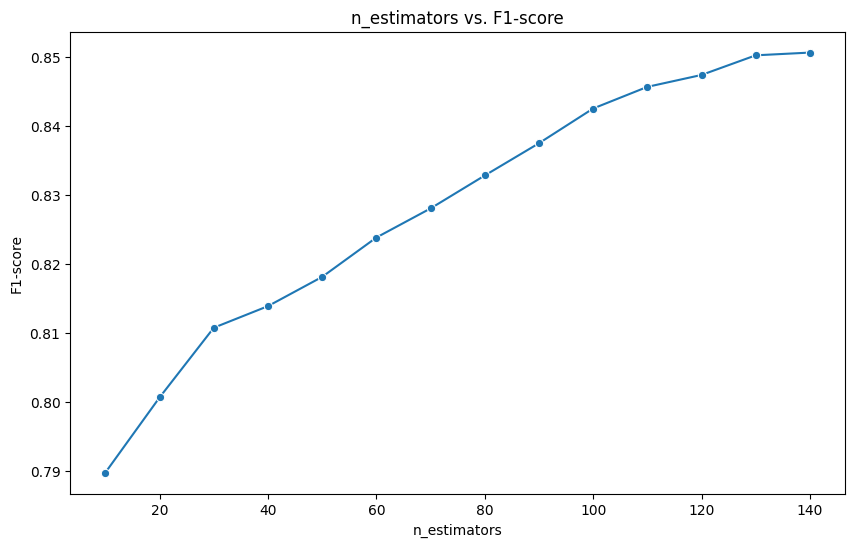

In [255]:
plt.figure(figsize=(10, 6))

# Plotting n_estimators vs. accuracy
sns.lineplot(x=list(range(10, 150, 10)), y=grid_search_n_estimators.cv_results_['mean_test_score'], marker='o')
plt.title('n_estimators vs. F1-score')
plt.xlabel('n_estimators')
plt.ylabel('F1-score')
plt.show()

More obvious improvement can been seen when n_estimators increases from 10 to 30, but after that the improvement is more subtle. Therefore, we will adopt n_estimators=30 for the following tuning.

##### Tune learning_rate

In [267]:
parameters_learning_rate = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
model = GradientBoostingClassifier(n_estimators=30, random_state=47)
grid_search_learning_rate = GridSearchCV(model, param_grid=parameters_learning_rate, cv=5, scoring='f1', verbose=3)
grid_search_learning_rate.fit(X_train[selected_columns], Y_train.values.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................learning_rate=0.01;, score=0.823 total time=   0.4s
[CV 2/5] END ................learning_rate=0.01;, score=0.771 total time=   0.4s
[CV 3/5] END ................learning_rate=0.01;, score=0.774 total time=   0.5s
[CV 4/5] END ................learning_rate=0.01;, score=0.775 total time=   0.5s
[CV 5/5] END ................learning_rate=0.01;, score=0.767 total time=   0.4s
[CV 1/5] END ................learning_rate=0.05;, score=0.818 total time=   0.5s
[CV 2/5] END ................learning_rate=0.05;, score=0.800 total time=   0.4s
[CV 3/5] END ................learning_rate=0.05;, score=0.800 total time=   0.4s
[CV 4/5] END ................learning_rate=0.05;, score=0.795 total time=   0.5s
[CV 5/5] END ................learning_rate=0.05;, score=0.790 total time=   0.5s
[CV 1/5] END .................learning_rate=0.1;, score=0.833 total time=   0.5s
[CV 2/5] END .................learning_rate=0.1;,

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=30,
                                                  random_state=47),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2]}, scoring='f1',
             verbose=3)

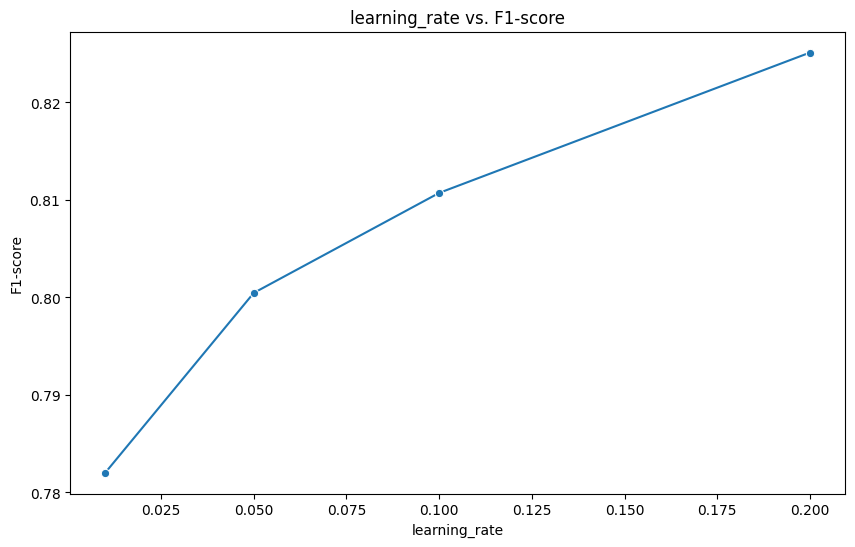

In [268]:
plt.figure(figsize=(10, 6))

# Plotting learning rate vs. accuracy
sns.lineplot(x=[0.01, 0.05, 0.1, 0.2], y=grid_search_learning_rate.cv_results_['mean_test_score'], marker='o')
plt.title('learning_rate vs. F1-score')
plt.xlabel('learning_rate')
plt.ylabel('F1-score')
plt.show()

learning_rate = 0.1 remains as the optimal solution, as after that the improvement is much slower.

##### Tune max_depth, min_samples_split, and min_samples_leaf

In [289]:
parameters_tree = {
    'max_depth':range(2,5,1), 
    'min_samples_split':[2, 5, 10, 20], 
    'min_samples_leaf': [1, 2, 5, 10]
    }
model = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, random_state=47)
grid_search_tree = GridSearchCV(model, param_grid=parameters_tree, cv=5, scoring='f1', verbose=3)
grid_search_tree.fit(X_train[selected_columns], Y_train.values.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.821 total time=   0.3s
[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.793 total time=   0.3s
[CV 3/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.794 total time=   0.4s
[CV 4/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.801 total time=   0.3s
[CV 5/5] END max_depth=2, min_samples_leaf=1, min_samples_split=2;, score=0.790 total time=   0.3s
[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=5;, score=0.821 total time=   0.3s
[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=5;, score=0.793 total time=   0.3s
[CV 3/5] END max_depth=2, min_samples_leaf=1, min_samples_split=5;, score=0.794 total time=   0.3s
[CV 4/5] END max_depth=2, min_samples_leaf=1, min_samples_split=5;, score=0.801 total time=   0.3s
[CV 5/5] END max_depth=2, min_samples_leaf=1, m

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=30,
                                                  random_state=47),
             param_grid={'max_depth': range(2, 5),
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1', verbose=3)

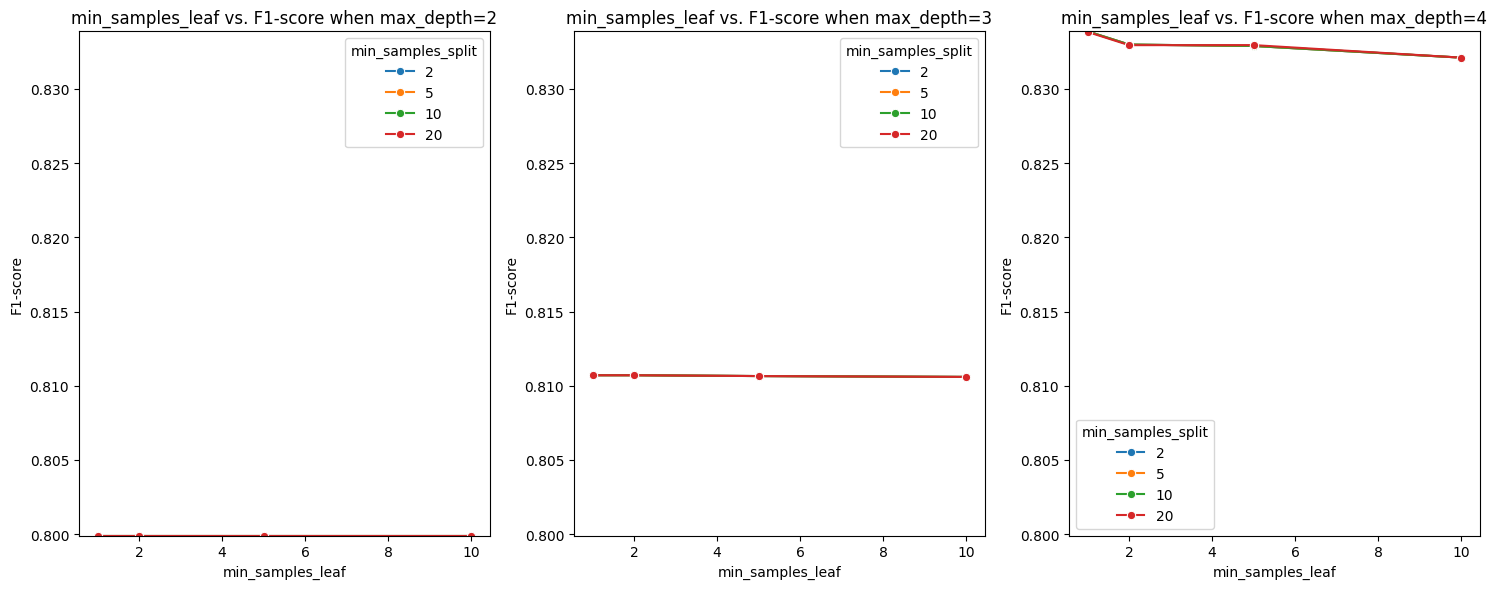

In [290]:
plt.figure(figsize=(15, 6))

# Plotting learning rate vs. accuracy
for i in range(3):
    plt.subplot(1, 3, i+1)
    for j in range(4):
        sns.lineplot(x=[1, 2, 5, 10], y=grid_search_tree.cv_results_['mean_test_score'][list(range(j+i*16, 16+i*16, 4))], marker='o', label=f'{[2, 5, 10, 20][j]}')
    plt.title(f'min_samples_leaf vs. F1-score when max_depth={[2,3,4][i]}')
    plt.ylim(min(grid_search_tree.cv_results_['mean_test_score']), max(grid_search_tree.cv_results_['mean_test_score']))
    plt.xlabel('min_samples_leaf')
    plt.ylabel('F1-score')
    plt.legend(title="min_samples_split") 
    plt.tight_layout()
plt.show()

The performance difference introcuded by min_samples_leaf and min_samples_split seems very subtle, so we will keep their default settings, i.e. min_samples_leaf=1 and min_samples_split=2. Subsequently, we want to tune max_depth alone to reveal clearer pattern.

##### Tune max_depth alone

In [300]:
parameters_max_depth = {
    'max_depth':range(2,8,1)
    }
model = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, random_state=47)
grid_search_max_depth = GridSearchCV(model, param_grid=parameters_max_depth, cv=5, scoring='f1', verbose=3)
grid_search_max_depth.fit(X_train[selected_columns], Y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .......................max_depth=2;, score=0.821 total time=   0.3s
[CV 2/5] END .......................max_depth=2;, score=0.793 total time=   0.3s
[CV 3/5] END .......................max_depth=2;, score=0.794 total time=   0.3s
[CV 4/5] END .......................max_depth=2;, score=0.801 total time=   0.3s
[CV 5/5] END .......................max_depth=2;, score=0.790 total time=   0.3s
[CV 1/5] END .......................max_depth=3;, score=0.833 total time=   0.4s
[CV 2/5] END .......................max_depth=3;, score=0.807 total time=   0.4s
[CV 3/5] END .......................max_depth=3;, score=0.813 total time=   0.4s
[CV 4/5] END .......................max_depth=3;, score=0.809 total time=   0.4s
[CV 5/5] END .......................max_depth=3;, score=0.791 total time=   0.4s
[CV 1/5] END .......................max_depth=4;, score=0.846 total time=   0.6s
[CV 2/5] END .......................max_depth=4;,

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=30,
                                                  random_state=47),
             param_grid={'max_depth': range(2, 8)}, scoring='f1', verbose=3)

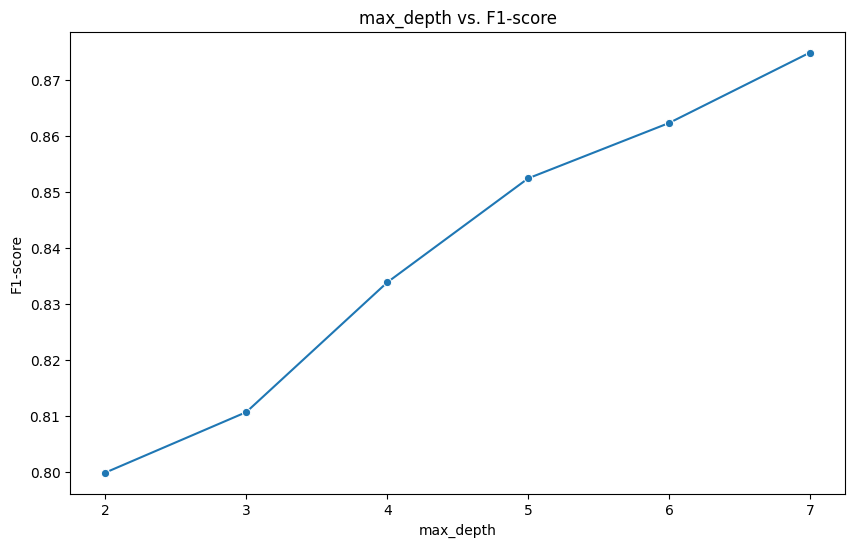

In [303]:
plt.figure(figsize=(10, 6))

# Plotting max_depth vs. accuracy
sns.lineplot(x=range(2,8,1), y=grid_search_max_depth.cv_results_['mean_test_score'], marker='o')
plt.title('max_depth vs. F1-score')
plt.xlabel('max_depth')
plt.ylabel('F1-score')
plt.show()

The results show that model performance keeps improving as max_depth increases. However, this may be because the model overfit to the training data. To avoid such situations from happening, we opt for a smaller max_depth and keep the default setting: max_depth=3.

##### Tune subsample and max_features

In [310]:
parameters_subsample = {
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'max_features': [None, 'log2', 'sqrt']
    }
model = GradientBoostingClassifier(n_estimators=30, learning_rate=0.1, min_samples_leaf=1, min_samples_split=2, max_depth=3, random_state=47)
grid_search_subsample = GridSearchCV(model, param_grid=parameters_subsample, cv=5, scoring='f1', verbose=3)
grid_search_subsample.fit(X_train[selected_columns], Y_train.values.ravel())

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ..max_features=None, subsample=0.5;, score=0.836 total time=   0.3s
[CV 2/5] END ..max_features=None, subsample=0.5;, score=0.806 total time=   0.3s
[CV 3/5] END ..max_features=None, subsample=0.5;, score=0.806 total time=   0.3s
[CV 4/5] END ..max_features=None, subsample=0.5;, score=0.808 total time=   0.3s
[CV 5/5] END ..max_features=None, subsample=0.5;, score=0.788 total time=   0.3s
[CV 1/5] END ..max_features=None, subsample=0.6;, score=0.833 total time=   0.3s
[CV 2/5] END ..max_features=None, subsample=0.6;, score=0.803 total time=   0.3s
[CV 3/5] END ..max_features=None, subsample=0.6;, score=0.811 total time=   0.3s
[CV 4/5] END ..max_features=None, subsample=0.6;, score=0.812 total time=   0.3s
[CV 5/5] END ..max_features=None, subsample=0.6;, score=0.789 total time=   0.4s
[CV 1/5] END ..max_features=None, subsample=0.7;, score=0.832 total time=   0.3s
[CV 2/5] END ..max_features=None, subsample=0.7;

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(n_estimators=30,
                                                  random_state=47),
             param_grid={'max_features': [None, 'log2', 'sqrt'],
                         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1]},
             scoring='f1', verbose=3)

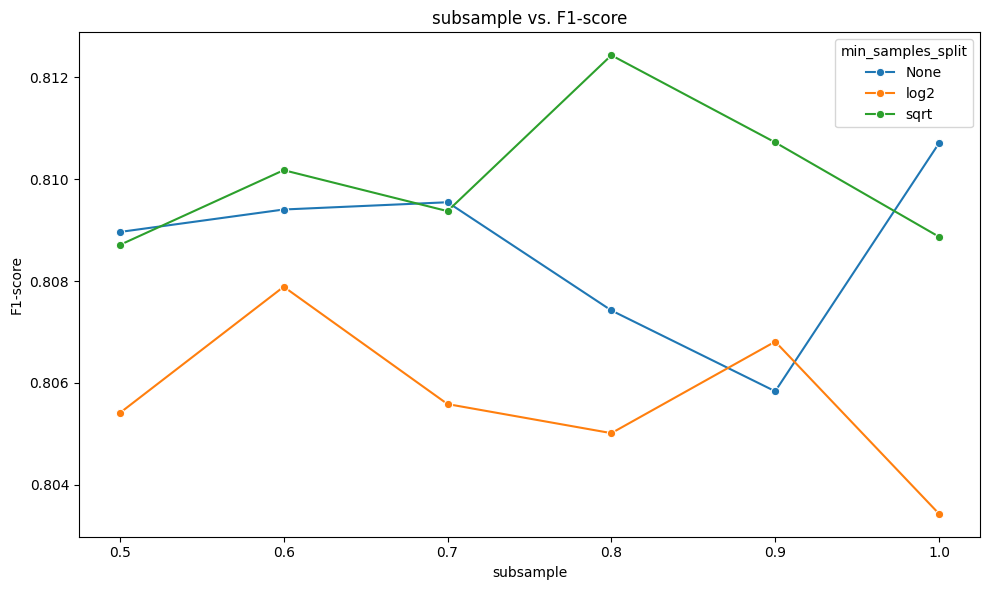

In [311]:
plt.figure(figsize=(10, 6))

# Plotting learning rate vs. accuracy
for i in range(3):
    sns.lineplot(x=[0.5, 0.6, 0.7, 0.8, 0.9, 1], y=grid_search_subsample.cv_results_['mean_test_score'][list(range(i*6, 6+i*6, 1))], marker='o', label=f"{['None', 'log2', 'sqrt'][i]}")
plt.title(f'subsample vs. F1-score')
plt.xlabel('subsample')
plt.ylabel('F1-score')
plt.legend(title="min_samples_split") 
plt.tight_layout()
plt.show()

The default setting: max_feature=None and subsample=1, remains an appealing option by providing the second best f1-score, so we will adopt that.

#### Fit the Model again the tuned hyperparameters

In [325]:
gb_tuned = GradientBoostingClassifier(n_estimators=30, random_state=47).fit(X_train[selected_columns], Y_train.values.ravel())

In [326]:
# Predict the output based on our training and testing dataset
Y_train_pred_tuned = gb_tuned.predict(X_train[selected_columns])
Y_test_pred_tuned = gb_tuned.predict(X_test[selected_columns])

In [424]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_tuned, Y_test, Y_test_pred_tuned, "Hyperparameter Tuned", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8169870537465673
Precision 	: 0.8164904034469251
Recall 		: 0.8177716751667321
F1 Score 	: 0.8171305370442964

**Test Set Metrics**
Accuracy 	: 0.8293786692759295
Precision 	: 0.6125490196078431
Recall 		: 0.4643281807372176
F1 Score 	: 0.5282380791342577


#### Eliminate Features with low in-built feature importance

In [393]:
# Get feature importance score
feature_importances = gb_tuned.feature_importances_
# Get feature names
feature_names = selected_columns

# Remove features with feature_importances<=0.001
feature_names = feature_names[feature_importances>0.001]
feature_importances = feature_importances[feature_importances>0.001]

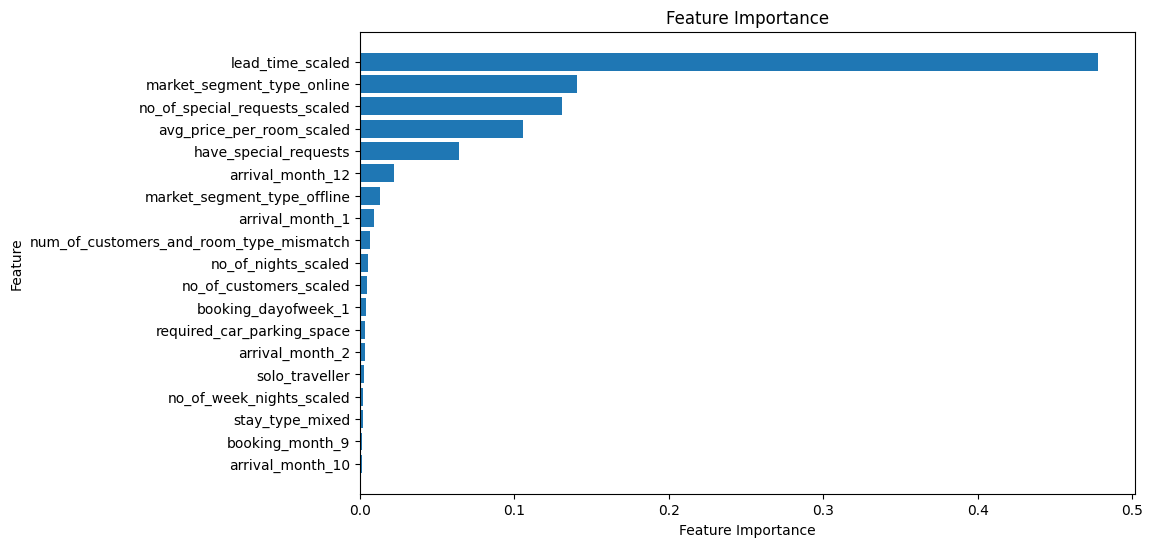

In [394]:
# Get indices that would sort feature importances
sorted_indices = np.argsort(feature_importances)
# Visualize permutation_importance
plot_feature_importance(feature_importances[sorted_indices], feature_names[sorted_indices])


Besides, there are some highly correlated columns, and we will remove one of them that contributes less to the model.

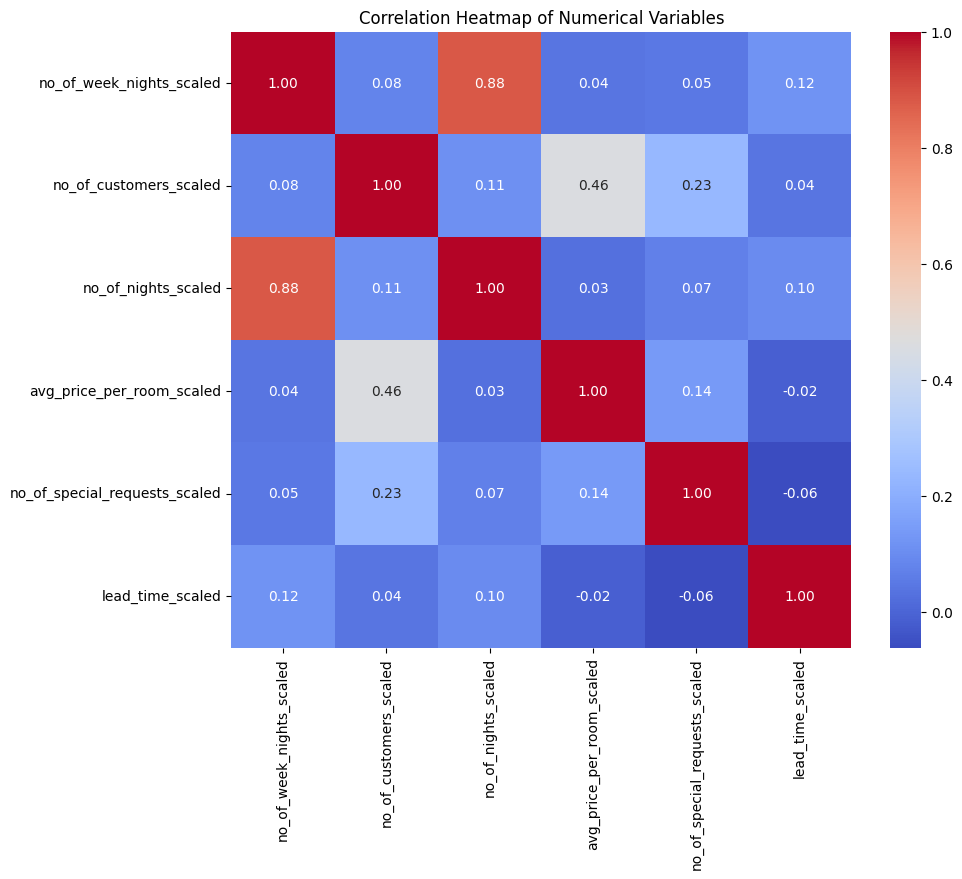

In [396]:
# test on numerical variables
num_cols = [x for x in feature_names[sorted_indices] if '_scaled' in x]
corr = X_train[num_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

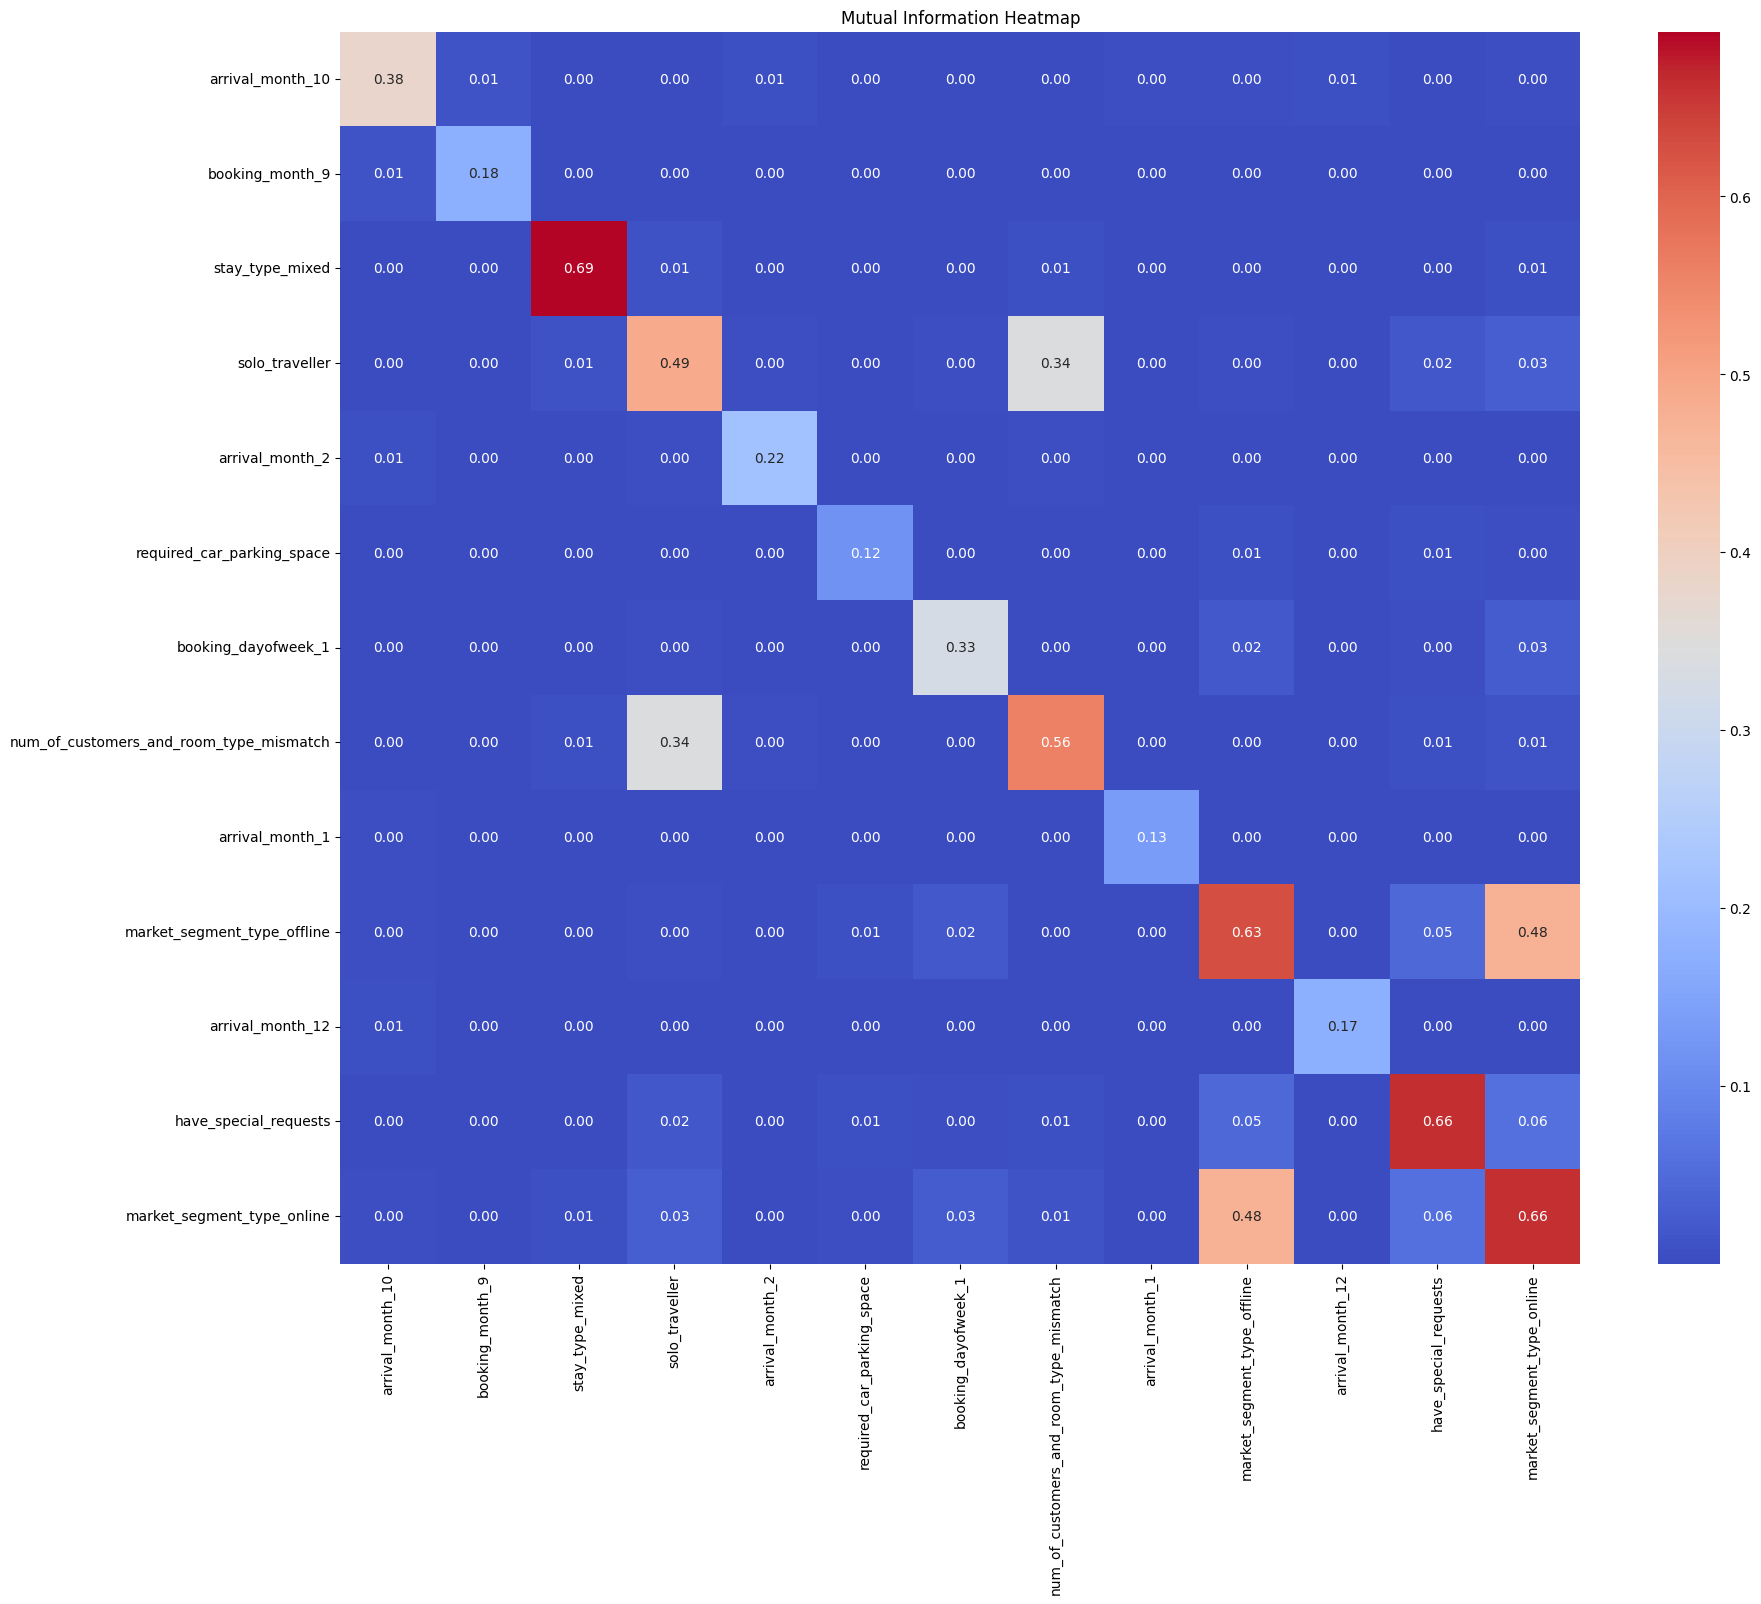

In [398]:
cat_cols = [x for x in feature_names[sorted_indices] if '_scaled' not in x]
# plot heatmap
mi_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)
for i in cat_cols:
    for j in cat_cols:
        mi_matrix.loc[i, j] = calculate_mutual_info(X_train, i, j)

plt.figure(figsize=(20, 16))  # Adjust the figure size if needed
sns.heatmap(mi_matrix.astype(float), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mutual Information Heatmap')
plt.show()

Based on the observations, 'no_of_week_nights_scaled', 'solo_traveller', 'market_segment_type_offline' will be removed.

In [399]:
to_remove = ['no_of_week_nights_scaled', 'solo_traveller', 'market_segment_type_offline']
final_columns = [x for x in feature_names[sorted_indices] if x not in to_remove]

#### Fit the model with the final set of features

In [400]:
gb_final = GradientBoostingClassifier(n_estimators=30, random_state=47).fit(X_train[final_columns], Y_train.values.ravel())

In [401]:
# Predict the output based on our training and testing dataset
Y_train_pred_final = gb_final.predict(X_train[final_columns])
Y_test_pred_final = gb_final.predict(X_test[final_columns])

In [425]:
train_metrics, test_metrics = evaluate(Y_train, Y_train_pred_final, Y_test, Y_test_pred_final, "Final", train_metrics, test_metrics)

**Training Set Metrics**
Accuracy 	: 0.8139466457434288
Precision 	: 0.8137005096040768
Recall 		: 0.8143389564535112
F1 Score 	: 0.8140196078431373

**Test Set Metrics**
Accuracy 	: 0.8323140900195695
Precision 	: 0.6257073565076798
Recall 		: 0.460166468489893
F1 Score 	: 0.5303186022610484


#### Evaluation

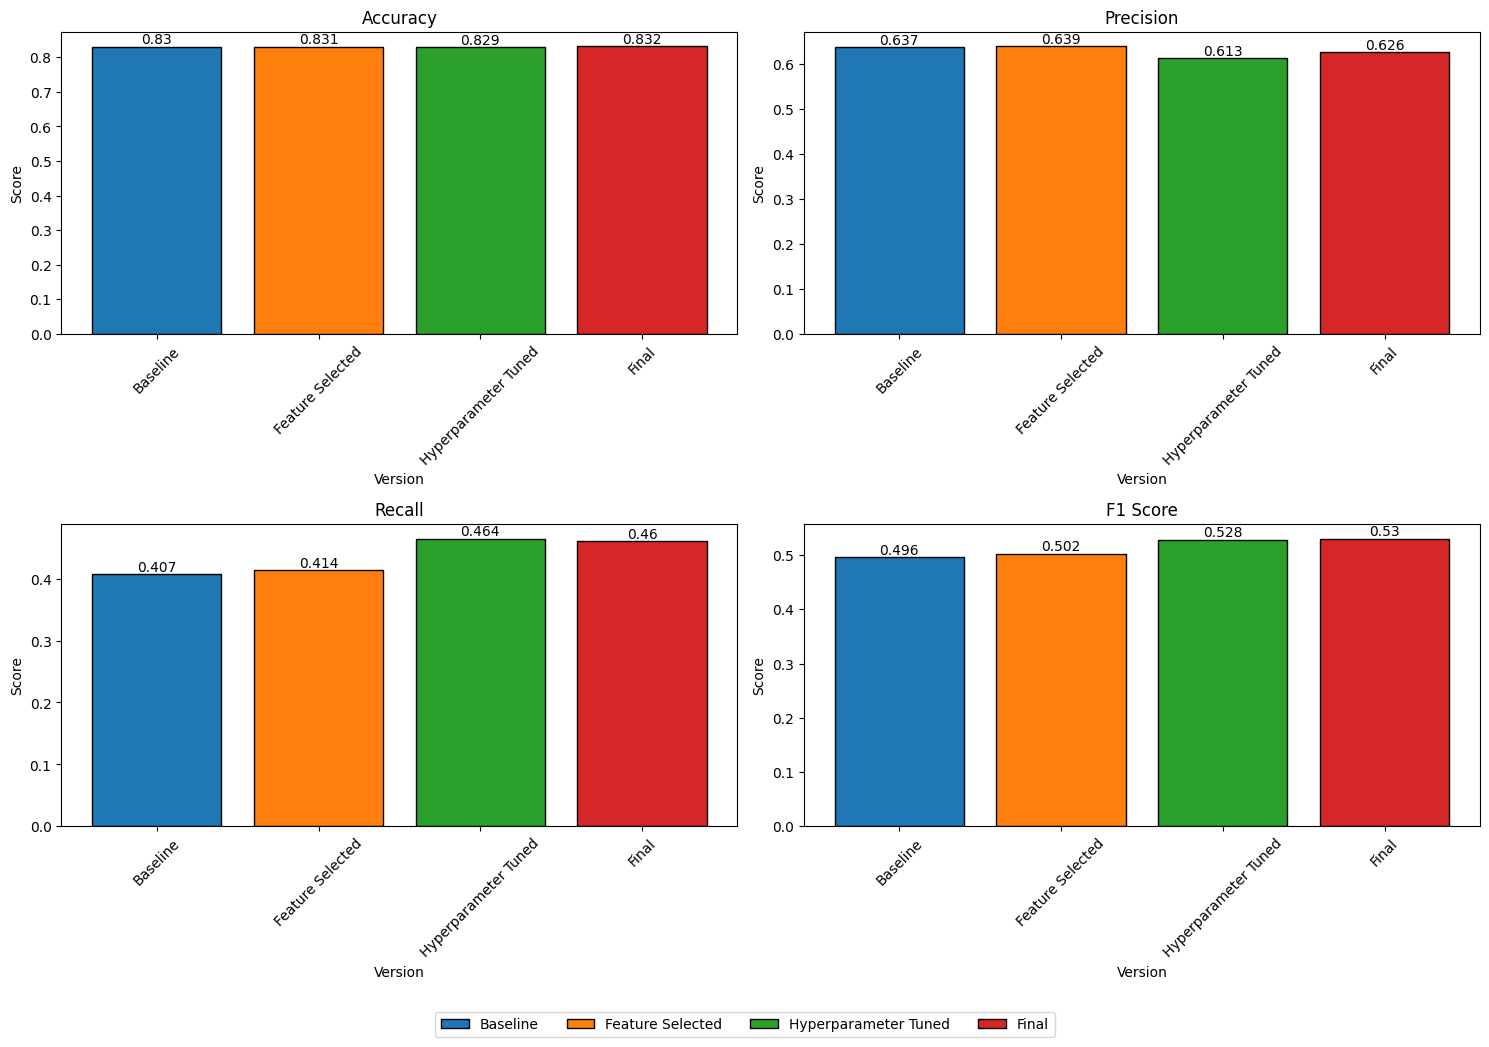

In [430]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

colormap = plt.cm.get_cmap('tab10')

for i, data in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
    colors = colormap.colors[:len(test_metrics['Version'])]
    for index, (model, value) in enumerate(zip(test_metrics['Version'], test_metrics[data])):
        axs[i].bar(model, value, color=colors[index], label=model if i == 0 else "", edgecolor='k')
    axs[i].set_title(data)
    axs[i].set_ylabel('Score')
    axs[i].set_xlabel('Version')
    axs[i].set_xticks(test_metrics['Version'])
    axs[i].set_xticklabels(test_metrics['Version'], rotation=45)
    for index, value in enumerate(test_metrics[data]):
        axs[i].text(index, value, str(round(value, 3)), ha='center', va='bottom')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.03), ncol=len(test_metrics['Version']))

plt.tight_layout()
plt.show()